In [3]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read all the words
words = open("names.txt", "r").read().splitlines()
print("total number of words : ", len(words))

total number of words :  32033


In [5]:
# build the vocablury

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}


In [6]:
# build the dataset

block_size = 3
x, y = [], []

for w in words[:]:
    # print(w)
    context = [0] * block_size

    for ch in w + ".":
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        # print("".join(itos[i] for i in context), " ----> ", itos[ix])
        context = context[1:] + [ix]

x = torch.tensor(x)
y = torch.tensor(y)




In [7]:
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [8]:
# build dataset
block_size = 3
def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)

    print(x.shape, y.shape)
    return x, y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27,10), generator=g, requires_grad=True)

W1 = torch.randn((C.shape[1] * block_size, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)


parameters = [C, W1, b1, W2, b2]
print("total parameters : ", sum(p.nelement() for p in parameters))

learning_rate = 0.1

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
losses = []
steps = []


total parameters :  11897


In [10]:

for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, xtr.shape[0], (32, ))
    print(x[ix].shape)

    # forward pass
    emb = C[x[ix]]
    print(emb.shape)
    emb.view(-1, 6).shape
    h = torch.tanh(emb.view(-1, C.shape[1]*block_size) @ W1 + b1)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()    

    # update parameters
    # learning_rate = lrs[_]
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

    # # track stats
    # lri.append(learning_rate)
    losses.append(loss.log10().item())
    steps.append(i)
    break

print(loss.item())

torch.Size([32, 3])
torch.Size([32, 3, 10])
25.613378524780273


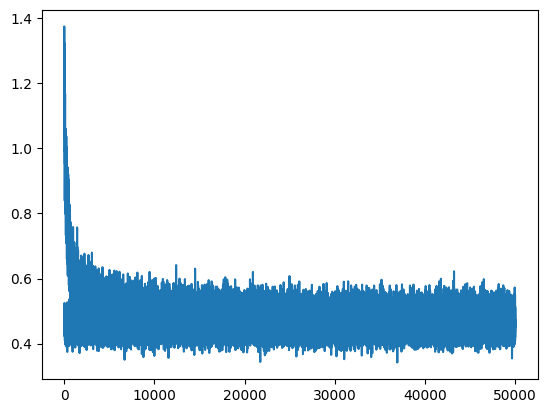

In [188]:
# plt.plot(lri, losses)
plt.plot(steps, losses)

In [189]:
# training forward pass
emb = C[xtr]
emb.view(-1, 6).shape
h = torch.tanh(emb.view(-1, C.shape[1] * block_size) @ W1 + b1)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytr)
print(loss)

# dev forward pass
emb = C[xdev]
emb.view(-1, 6).shape
h = torch.tanh(emb.view(-1, C.shape[1] * block_size) @ W1 + b1)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
print(loss)

tensor(2.8517, grad_fn=<NllLossBackward0>)
tensor(2.8504, grad_fn=<NllLossBackward0>)


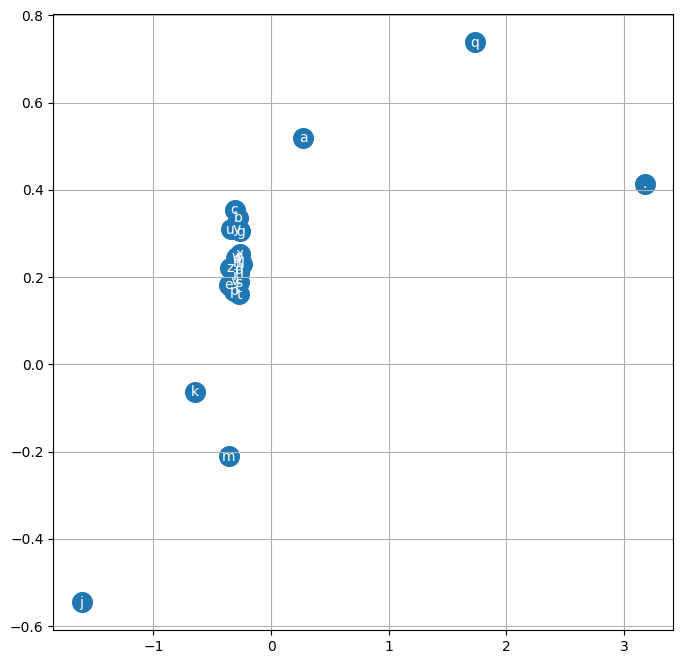

In [178]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")